# Avaliação da Versão Completa do Chatbot LAI

Este notebook implementa as métricas de avaliação para a versão completa do chatbot LAI (BERT + FAISS).

In [46]:
import os
import time
import faiss
import numpy as np
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize
from sklearn.metrics import precision_score, recall_score, f1_score


## 1. Carregar Artigos e Configurar Modelo

In [47]:
def carregar_artigos(caminho_txt="sentencas.txt"):
    artigos = []
    with open(caminho_txt, "r", encoding="utf-8") as f:
        bloco = ""
        artigo_id = ""
        for linha in f:
            linha = linha.strip()
            if linha.startswith("[ARTIGO_"):
                if artigo_id and bloco:
                    artigos.append({"id": artigo_id, "texto": bloco.strip()})
                artigo_id = linha.strip("[]")
                bloco = ""
            else:
                bloco += " " + linha
        if artigo_id and bloco:
            artigos.append({"id": artigo_id, "texto": bloco.strip()})
    return artigos

# Carregar artigos
print("[*] Carregando artigos...")
artigos = carregar_artigos("sentencas.txt")
print(f"[*] {len(artigos)} artigos carregados.")

# Exibir os primeiros 3 artigos como exemplo
for i, artigo in enumerate(artigos[:3]):
    print(f"\nArtigo {i+1}: {artigo['id']}")
    print(f"Texto: {artigo['texto'][:150]}...")


[*] Carregando artigos...
[*] 50 artigos carregados.

Artigo 1: ARTIGO_1
Texto: Art. 1o Esta Lei dispoe sobre os procedimentos a serem observados pela Uniao, Estados, Distrito Federal e Municipios, com o fim de garantir o acesso a...

Artigo 2: ARTIGO_2
Texto: Art. 2o Aplicam-se as disposicoes desta Lei, no que couber, as entidades privadas sem fins lucrativos que recebam, para realizacao de acoes de interes...

Artigo 3: ARTIGO_3
Texto: Art. 3o Os procedimentos previstos nesta Lei destinam-se a assegurar o direito fundamental de acesso a informacao e devem ser executados em conformida...


## 1.1 Carregar Entidades Nomeadas e Tokens Filtrados


In [48]:
# Função para carregar entidades nomeadas
def carregar_entidades(caminho_entidades="entidades_filtradas.txt"):
    print(f"[*] Carregando entidades de {caminho_entidades}...")
    entidades = []
    with open(caminho_entidades, "r", encoding="utf-8") as f:
        next(f)  # Pular cabeçalho
        for linha in f:
            if linha.strip():
                partes = linha.strip().split("\t")
                if len(partes) >= 2:
                    entidade, label = partes[0], partes[1]
                    entidades.append({"texto": entidade, "tipo": label})
    print(f"[*] {len(entidades)} entidades carregadas.")
    return entidades

# Função para carregar tokens filtrados
def carregar_tokens(caminho_tokens="tokens_filtrados.txt"):
    print(f"[*] Carregando tokens de {caminho_tokens}...")
    tokens = []
    with open(caminho_tokens, "r", encoding="utf-8") as f:
        next(f)  # Pular cabeçalho
        for linha in f:
            if linha.strip():
                partes = linha.strip().split("\t")
                if len(partes) >= 3:
                    texto, lemma, pos = partes[0], partes[1], partes[2]
                    tokens.append({"texto": texto, "lemma": lemma, "pos": pos})
    print(f"[*] {len(tokens)} tokens carregados.")
    return tokens

# Carregar entidades e tokens
entidades_filtradas = carregar_entidades("entidades_filtradas.txt")
entidades_ner = carregar_entidades("entidades_ner.txt")
tokens_filtrados = carregar_tokens("tokens_filtrados.txt")

# Criar dicionários para acesso rápido
entidades_dict = {e["texto"].lower(): e["tipo"] for e in entidades_filtradas}
entidades_ner_dict = {e["texto"].lower(): e["tipo"] for e in entidades_ner}
tokens_importantes = {t["texto"].lower(): t["pos"] for t in tokens_filtrados if t["pos"] in ["NOUN", "VERB", "ADJ", "PROPN"]}


[*] Carregando entidades de entidades_filtradas.txt...
[*] 74 entidades carregadas.
[*] Carregando entidades de entidades_ner.txt...
[*] 375 entidades carregadas.
[*] Carregando tokens de tokens_filtrados.txt...
[*] 3731 tokens carregados.


## 1.2 Enriquecer Artigos com Entidades e Tokens


In [49]:
def enriquecer_texto(texto, entidades_dict, entidades_ner_dict, tokens_importantes):
    """Enriquece o texto identificando entidades e tokens importantes"""
    import re
    from unidecode import unidecode
    
    # Normalização básica
    texto = texto.lower()
    texto = re.sub(r'art\.\s*\d+º?', '', texto)  # Remover referências a artigos
    texto = re.sub(r'§\s*\d+º?', '', texto)  # Remover parágrafos
    texto = re.sub(r'^\s*\d+\.\s*', '', texto)  # Remover numerações
    
    # Manter o texto original para busca de entidades
    texto_original = texto
    texto_enriquecido = texto
    
    # Adicionar marcadores para entidades filtradas (com repetição para dar mais peso)
    for entidade, tipo in entidades_dict.items():
        entidade_norm = entidade.lower()
        if entidade_norm in texto_original.lower():
            # Repetir 3x para dar mais peso
            texto_enriquecido += f" [ENTIDADE:{entidade}:{tipo}] [ENTIDADE:{entidade}:{tipo}] [ENTIDADE:{entidade}:{tipo}]"
    
    # Adicionar marcadores para entidades NER (com repetição para dar mais peso)
    for entidade, tipo in entidades_ner_dict.items():
        entidade_norm = entidade.lower()
        if entidade_norm in texto_original.lower() and len(entidade) > 3:  # Filtrar entidades muito curtas
            # Repetir 2x para dar mais peso
            texto_enriquecido += f" [NER:{entidade}:{tipo}] [NER:{entidade}:{tipo}]"
    
    # Adicionar tokens importantes com mais peso para substantivos e verbos
    palavras = texto_original.lower().split()
    tokens_encontrados = [token for token in palavras if token in tokens_importantes]
    for token in tokens_encontrados:
        pos = tokens_importantes[token]
        # Dar peso extra para substantivos e verbos
        if pos in ["NOUN", "PROPN"]:
            texto_enriquecido += f" [TOKEN:{token}:{pos}] [TOKEN:{token}:{pos}] [TOKEN:{token}:{pos}]"
        elif pos == "VERB":
            texto_enriquecido += f" [TOKEN:{token}:{pos}] [TOKEN:{token}:{pos}]"
        else:
            texto_enriquecido += f" [TOKEN:{token}:{pos}]"
    
    return texto_enriquecido

# Enriquecer artigos com entidades e tokens
print("[*] Enriquecendo artigos com entidades e tokens...")
for artigo in tqdm(artigos):
    artigo["texto_enriquecido"] = enriquecer_texto(
        artigo["texto"], 
        entidades_dict, 
        entidades_ner_dict, 
        tokens_importantes
    )

# Exibir um exemplo de texto enriquecido
print("\n[*] Exemplo de texto enriquecido:")
print(f"Original: {artigos[0]['texto'][:150]}...")
print(f"Enriquecido: {artigos[0]['texto_enriquecido'][:150]}...")


[*] Enriquecendo artigos com entidades e tokens...


100%|██████████| 50/50 [00:00<00:00, 960.81it/s]


[*] Exemplo de texto enriquecido:
Original: Art. 1o Esta Lei dispoe sobre os procedimentos a serem observados pela Uniao, Estados, Distrito Federal e Municipios, com o fim de garantir o acesso a...
Enriquecido: o esta lei dispoe sobre os procedimentos a serem observados pela uniao, estados, distrito federal e municipios, com o fim de garantir o acesso a infor...


## 2. Gerar Embeddings com BERT (Versão Completa)

In [50]:
def gerar_embeddings_bert(textos, modelo='neuralmind/bert-base-portuguese-cased', batch_size=32):
    print("[*] Carregando modelo BERT...")
    # Modelo usado na versão completa
    model = SentenceTransformer(modelo)
    
    # Configurar parâmetros do modelo para melhorar a performance
    model.max_seq_length = 512  # Aumentar o tamanho máximo da sequência
    
    print("[*] Gerando embeddings...")
    start_time = time.time()
    
    # Usar batch_size maior para acelerar o processamento
    embeddings = model.encode(textos, show_progress_bar=True, batch_size=batch_size)
    
    # Normalizar embeddings para comparação por similaridade de cosseno
    embeddings = normalize(embeddings)
    
    end_time = time.time()
    print(f"[*] Embeddings gerados em {end_time - start_time:.2f} segundos.")
    return embeddings, model

# Extrair textos enriquecidos em vez dos textos originais
textos = [a["texto_enriquecido"] for a in artigos]

# Experimentar com um modelo alternativo que pode ter melhor performance
# modelo_alternativo = 'paraphrase-multilingual-MiniLM-L12-v2'  # Modelo menor e mais rápido treinado para similaridade
modelo_bert = 'neuralmind/bert-base-portuguese-cased'  # Mantendo o modelo original

# Gerar embeddings com configurações otimizadas
embeddings, model = gerar_embeddings_bert(textos, modelo=modelo_bert, batch_size=32)


[*] Carregando modelo BERT...


No sentence-transformers model found with name neuralmind/bert-base-portuguese-cased. Creating a new one with mean pooling.


[*] Gerando embeddings...


Batches: 100%|██████████| 2/2 [00:21<00:00, 10.55s/it]

[*] Embeddings gerados em 21.13 segundos.


## 3. Criar Índice FAISS

In [51]:
def criar_index_faiss(embeddings):
    print("[*] Criando índice FAISS...")
    dim = embeddings.shape[1]
    index = faiss.IndexFlatIP(dim)
    index.add(embeddings)
    print(f"[*] Índice criado com {index.ntotal} vetores de dimensão {dim}.")
    return index

index = criar_index_faiss(embeddings)


[*] Criando índice FAISS...
[*] Índice criado com 50 vetores de dimensão 768.


## 4. Conjunto de Perguntas para Avaliação

Criamos um conjunto de perguntas de teste com respostas esperadas (artigos relevantes)


In [52]:
# Conjunto de perguntas de teste com artigos relevantes esperados
perguntas_teste = [
    {
        "pergunta": "O que é a Lei de Acesso à Informação?",
        "artigos_relevantes": ["ARTIGO_1", "ARTIGO_2", "PREAMBULO"]
    },
    {
        "pergunta": "Como solicitar informações públicas?",
        "artigos_relevantes": ["ARTIGO_10", "ARTIGO_11", "ARTIGO_12"]
    },
    {
        "pergunta": "Qual o prazo para resposta do pedido de informação?",
        "artigos_relevantes": ["ARTIGO_11", "ARTIGO_15", "ARTIGO_16"]
    },
    {
        "pergunta": "Quais informações podem ser negadas?",
        "artigos_relevantes": ["ARTIGO_21", "ARTIGO_22", "ARTIGO_23", "ARTIGO_24"]
    },
    {
        "pergunta": "Quem pode solicitar informações públicas?",
        "artigos_relevantes": ["ARTIGO_10", "ARTIGO_11"]
    },
    {
        "pergunta": "Quais são as informações classificadas como sigilosas?",
        "artigos_relevantes": ["ARTIGO_23", "ARTIGO_24", "ARTIGO_25"]
    },
    {
        "pergunta": "Quais são as penalidades para quem não cumprir a LAI?",
        "artigos_relevantes": ["ARTIGO_32", "ARTIGO_33", "ARTIGO_34"]
    },
    {
        "pergunta": "Como recorrer de uma negativa de acesso à informação?",
        "artigos_relevantes": ["ARTIGO_15", "ARTIGO_16", "ARTIGO_17"]
    },
    {
        "pergunta": "Quais são os prazos de sigilo das informações?",
        "artigos_relevantes": ["ARTIGO_24", "ARTIGO_27", "ARTIGO_28"]
    },
    {
        "pergunta": "Como a LAI protege informações pessoais?",
        "artigos_relevantes": ["ARTIGO_31", "ARTIGO_32"]
    },
    {
        "pergunta": "Quais são os princípios da Lei de Acesso à Informação?",
        "artigos_relevantes": ["ARTIGO_3", "ARTIGO_5", "ARTIGO_6"]
    },
    {
        "pergunta": "O que são informações sigilosas segundo a LAI?",
        "artigos_relevantes": ["ARTIGO_4", "ARTIGO_23", "ARTIGO_24"]
    },
    {
        "pergunta": "Como é feita a classificação de informações sigilosas?",
        "artigos_relevantes": ["ARTIGO_24", "ARTIGO_25", "ARTIGO_26", "ARTIGO_27"]
    },
    {
        "pergunta": "Quais são os direitos do cidadão garantidos pela LAI?",
        "artigos_relevantes": ["ARTIGO_7", "ARTIGO_8", "ARTIGO_9", "ARTIGO_10"]
    },
    {
        "pergunta": "Quais informações devem ser divulgadas proativamente pelos órgãos públicos?",
        "artigos_relevantes": ["ARTIGO_8", "ARTIGO_9"]
    },
    {
        "pergunta": "Como funciona o recurso em caso de negativa de acesso à informação?",
        "artigos_relevantes": ["ARTIGO_15", "ARTIGO_16", "ARTIGO_17", "ARTIGO_18", "ARTIGO_19"]
    },
    {
        "pergunta": "Quais são as responsabilidades dos órgãos públicos em relação à LAI?",
        "artigos_relevantes": ["ARTIGO_6", "ARTIGO_7", "ARTIGO_8", "ARTIGO_9"]
    },
    {
        "pergunta": "Como é tratada a informação pessoal pela LAI?",
        "artigos_relevantes": ["ARTIGO_4", "ARTIGO_31"]
    },
    {
        "pergunta": "Qual a diferença entre informação sigilosa e informação pessoal?",
        "artigos_relevantes": ["ARTIGO_4", "ARTIGO_23", "ARTIGO_31"]
    },
    {
        "pergunta": "Como solicitar a desclassificação de uma informação sigilosa?",
        "artigos_relevantes": ["ARTIGO_17", "ARTIGO_29", "ARTIGO_30"]
    }
]

print(f"[*] {len(perguntas_teste)} perguntas de teste carregadas.")


[*] 20 perguntas de teste carregadas.


## 5. Função de Busca e Avaliação

In [53]:
def buscar_pergunta(pergunta, model, index, artigos, top_k=30, entidades_dict=None, entidades_ner_dict=None, tokens_importantes=None):
    """Busca os artigos mais relevantes para uma pergunta"""
    start_time = time.time()
    
    # Enriquecer a pergunta com entidades e tokens importantes
    if entidades_dict and entidades_ner_dict and tokens_importantes:
        pergunta_enriquecida = enriquecer_texto(pergunta, entidades_dict, entidades_ner_dict, tokens_importantes)
    else:
        pergunta_enriquecida = pergunta
    
    # Gerar embedding da pergunta enriquecida
    pergunta_embedding = model.encode([pergunta_enriquecida])
    pergunta_embedding = normalize(pergunta_embedding)
    
    # Buscar no índice FAISS com top_k aumentado para recuperar mais candidatos
    # e depois aplicar um re-ranking mais preciso
    distancias, indices = index.search(pergunta_embedding, top_k)
    
    # Calcular tempo de resposta
    tempo_resposta = time.time() - start_time
    
    # Recuperar artigos
    resultados = []
    for i, idx in enumerate(indices[0]):
        artigo = artigos[idx]
        
        # Calcular similaridade com base em tokens e entidades compartilhadas
        # para melhorar o ranking
        texto_artigo = artigo["texto"].lower()
        pergunta_tokens = set(pergunta.lower().split())
        artigo_tokens = set(texto_artigo.split())
        tokens_comuns = len(pergunta_tokens.intersection(artigo_tokens))
        
        # Bonus para entidades compartilhadas
        bonus_entidades = 0
        if entidades_dict:
            for entidade in entidades_dict:
                if entidade.lower() in pergunta.lower() and entidade.lower() in texto_artigo:
                    bonus_entidades += 0.15  # Bonus de 15% por entidade compartilhada
        
        # Score combinado: distância FAISS + bonus de tokens e entidades
        score_combinado = float(distancias[0][i]) * (1 + bonus_entidades + tokens_comuns * 0.02)
        
        resultados.append({
            "rank": i + 1,
            "id": artigo["id"],
            "texto": artigo["texto"],
            "similaridade": score_combinado
        })
    
    # Re-ordenar resultados pelo score combinado
    resultados = sorted(resultados, key=lambda x: x["similaridade"], reverse=True)
    
    # Atualizar ranks após reordenação
    for i, resultado in enumerate(resultados):
        resultado["rank"] = i + 1
    
    return resultados[:10], tempo_resposta  # Retornar apenas os top 10 após re-ranking

def calcular_precision_at_k(resultados, artigos_relevantes, k=5):
    """Calcula a precisão@k"""
    hits = 0
    for i in range(min(k, len(resultados))):
        if resultados[i]["id"] in artigos_relevantes:
            hits += 1
    return hits / k

def calcular_recall_at_k(resultados, artigos_relevantes, k=10):
    """Calcula o recall@k"""
    hits = 0
    for i in range(min(k, len(resultados))):
        if resultados[i]["id"] in artigos_relevantes:
            hits += 1
    return hits / len(artigos_relevantes) if artigos_relevantes else 0

def calcular_f1_at_k(precision, recall):
    """Calcula o F1-score a partir da precisão e recall"""
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

def calcular_ndcg_at_k(resultados, artigos_relevantes, k=10):
    """Calcula o NDCG@k (Normalized Discounted Cumulative Gain)"""
    import numpy as np
    
    # Criar vetor de relevância (1 se relevante, 0 se não)
    relevancia = np.zeros(min(k, len(resultados)))
    for i in range(min(k, len(resultados))):
        if resultados[i]["id"] in artigos_relevantes:
            relevancia[i] = 1
    
    # Calcular DCG
    dcg = relevancia[0]
    for i in range(1, len(relevancia)):
        dcg += relevancia[i] / np.log2(i + 2)  # +2 porque i começa em 0 e log_2(1) = 0
    
    # Calcular IDCG (DCG ideal - todos os relevantes no topo)
    n_relevantes = min(len(artigos_relevantes), k)
    idcg = 0
    for i in range(n_relevantes):
        if i == 0:
            idcg += 1
        else:
            idcg += 1 / np.log2(i + 2)
    
    # Calcular NDCG
    if idcg == 0:
        return 0
    return dcg / idcg

def calcular_mrr(resultados, artigos_relevantes):
    """Calcula o MRR (Mean Reciprocal Rank)"""
    for i, resultado in enumerate(resultados):
        if resultado["id"] in artigos_relevantes:
            return 1.0 / (i + 1)  # Retorna 1/rank do primeiro resultado relevante
    return 0  # Se nenhum resultado relevante for encontrado


## 6. Executar Avaliação


In [54]:
# Inicializar listas para armazenar resultados
resultados_avaliacao = []
tempos_resposta = []
precision_at_5_list = []
recall_at_10_list = []
f1_scores = []
ndcg_list = []
mrr_list = []

# Avaliar cada pergunta
for i, pergunta_teste in enumerate(perguntas_teste):
    print(f"\n[*] Avaliando pergunta {i+1}: {pergunta_teste['pergunta']}")
    
    # Buscar artigos relevantes
    resultados, tempo = buscar_pergunta(
        pergunta_teste["pergunta"], 
        model, 
        index, 
        artigos, 
        top_k=10,
        entidades_dict=entidades_dict,
        entidades_ner_dict=entidades_ner_dict,
        tokens_importantes=tokens_importantes
    )
    
    # Calcular métricas
    precision_at_5 = calcular_precision_at_k(resultados, pergunta_teste["artigos_relevantes"], k=5)
    recall_at_10 = calcular_recall_at_k(resultados, pergunta_teste["artigos_relevantes"], k=10)
    f1 = calcular_f1_at_k(precision_at_5, recall_at_10)
    ndcg = calcular_ndcg_at_k(resultados, pergunta_teste["artigos_relevantes"], k=10)
    mrr = calcular_mrr(resultados, pergunta_teste["artigos_relevantes"])
    
    # Armazenar resultados
    resultados_avaliacao.append({
        "pergunta": pergunta_teste["pergunta"],
        "artigos_relevantes_esperados": pergunta_teste["artigos_relevantes"],
        "artigos_encontrados": [r["id"] for r in resultados[:10]],
        "precision_at_5": precision_at_5,
        "recall_at_10": recall_at_10,
        "f1_score": f1,
        "ndcg": ndcg,
        "mrr": mrr,
        "tempo_resposta": tempo
    })
    
    tempos_resposta.append(tempo)
    precision_at_5_list.append(precision_at_5)
    recall_at_10_list.append(recall_at_10)
    f1_scores.append(f1)
    ndcg_list.append(ndcg)
    mrr_list.append(mrr)
    
    # Exibir artigos relevantes e encontrados
    artigos_encontrados_ids = [r["id"] for r in resultados[:10]]
    
    # Identificar acertos nos primeiros 5 resultados (para precision@5)
    acertos_top5 = []
    for j in range(min(5, len(artigos_encontrados_ids))):
        if artigos_encontrados_ids[j] in pergunta_teste["artigos_relevantes"]:
            acertos_top5.append(f"✓ {artigos_encontrados_ids[j]}")
        else:
            acertos_top5.append(f"✗ {artigos_encontrados_ids[j]}")
    
    # Identificar acertos nos resultados 6-10 (para recall@10)
    acertos_6_10 = []
    for j in range(5, min(10, len(artigos_encontrados_ids))):
        if artigos_encontrados_ids[j] in pergunta_teste["artigos_relevantes"]:
            acertos_6_10.append(f"✓ {artigos_encontrados_ids[j]}")
        else:
            acertos_6_10.append(f"✗ {artigos_encontrados_ids[j]}")
    
    print(f"  - Artigos relevantes esperados: {pergunta_teste['artigos_relevantes']}")
    print(f"  - Artigos encontrados (top 5): {acertos_top5}")
    print(f"  - Artigos encontrados (6-10): {acertos_6_10}")
    print(f"  - Precision@5: {precision_at_5:.3f}")
    print(f"  - Recall@10: {recall_at_10:.3f}")
    print(f"  - F1-Score: {f1:.3f}")
    print(f"  - Tempo de resposta: {tempo:.3f}s")



[*] Avaliando pergunta 1: O que é a Lei de Acesso à Informação?
  - Artigos relevantes esperados: ['ARTIGO_1', 'ARTIGO_2', 'PREAMBULO']
  - Artigos encontrados (top 5): ['✗ ARTIGO_5', '✗ ARTIGO_43', '✗ ARTIGO_20', '✗ ARTIGO_42', '✗ ARTIGO_46']
  - Artigos encontrados (6-10): ['✗ ARTIGO_44', '✗ ARTIGO_38', '✗ ARTIGO_21', '✗ ARTIGO_14', '✗ ARTIGO_36']
  - Precision@5: 0.000
  - Recall@10: 0.000
  - F1-Score: 0.000
  - Tempo de resposta: 0.142s

[*] Avaliando pergunta 2: Como solicitar informações públicas?
  - Artigos relevantes esperados: ['ARTIGO_10', 'ARTIGO_11', 'ARTIGO_12']
  - Artigos encontrados (top 5): ['✗ ARTIGO_43', '✗ ARTIGO_3', '✗ ARTIGO_42', '✗ ARTIGO_36', '✗ ARTIGO_5']
  - Artigos encontrados (6-10): ['✗ ARTIGO_38', '✗ ARTIGO_14', '✗ ARTIGO_44', '✓ ARTIGO_10', '✗ ARTIGO_46']
  - Precision@5: 0.000
  - Recall@10: 0.333
  - F1-Score: 0.000
  - Tempo de resposta: 0.057s

[*] Avaliando pergunta 3: Qual o prazo para resposta do pedido de informação?
  - Artigos relevantes espe

## 7. Resumo dos Resultados


In [55]:
# Calcular médias
media_precision_at_5 = np.mean(precision_at_5_list)
media_recall_at_10 = np.mean(recall_at_10_list)
media_f1 = np.mean(f1_scores)
media_ndcg = np.mean(ndcg_list)
media_mrr = np.mean(mrr_list)
media_tempo_resposta = np.mean(tempos_resposta)

print("\n=== RESULTADOS DA AVALIAÇÃO (VERSÃO COMPLETA - BERT + FAISS + ENTIDADES OTIMIZADA) ===")
print(f"Precision@5 média: {media_precision_at_5:.3f}")
print(f"Recall@10 média: {media_recall_at_10:.3f}")
print(f"F1-Score médio: {media_f1:.3f}")
print(f"NDCG@10 médio: {media_ndcg:.3f}")
print(f"MRR médio: {media_mrr:.3f}")
print(f"Tempo médio de resposta: {media_tempo_resposta:.3f}s")

# Criar DataFrame para visualização
df_resultados = pd.DataFrame(resultados_avaliacao)
df_resultados[['pergunta', 'precision_at_5', 'recall_at_10', 'f1_score', 'tempo_resposta']]



=== RESULTADOS DA AVALIAÇÃO (VERSÃO COMPLETA - BERT + FAISS + ENTIDADES OTIMIZADA) ===
Precision@5 média: 0.150
Recall@10 média: 0.314
F1-Score médio: 0.191
NDCG@10 médio: 0.253
MRR médio: 0.366
Tempo médio de resposta: 0.075s


,pergunta,precision_at_5,recall_at_10,f1_score,tempo_resposta
0,O que é a Lei de Acesso à Informação?,0.0,0.000000,0.000000,0.141994
1,Como solicitar informações públicas?,0.0,0.333333,0.000000,0.057008
2,Qual o prazo para resposta do pedido de inform...,0.2,0.333333,0.250000,0.088014
3,Quais informações podem ser negadas?,0.0,0.250000,0.000000,0.036516
4,Quem pode solicitar informações públicas?,0.2,0.500000,0.285714,0.052144
5,Quais são as informações classificadas como si...,0.2,0.333333,0.250000,0.053727
6,Quais são as penalidades para quem não cumprir...,0.4,0.666667,0.500000,0.038647
7,Como recorrer de uma negativa de acesso à info...,0.2,0.333333,0.250000,0.110102
8,Quais são os prazos de sigilo das informações?,0.0,0.000000,0.000000,0.157052
9,Como a LAI protege informações pessoais?,0.4,1.000000,0.571429,0.042011


## 8. Visualização dos Resultados

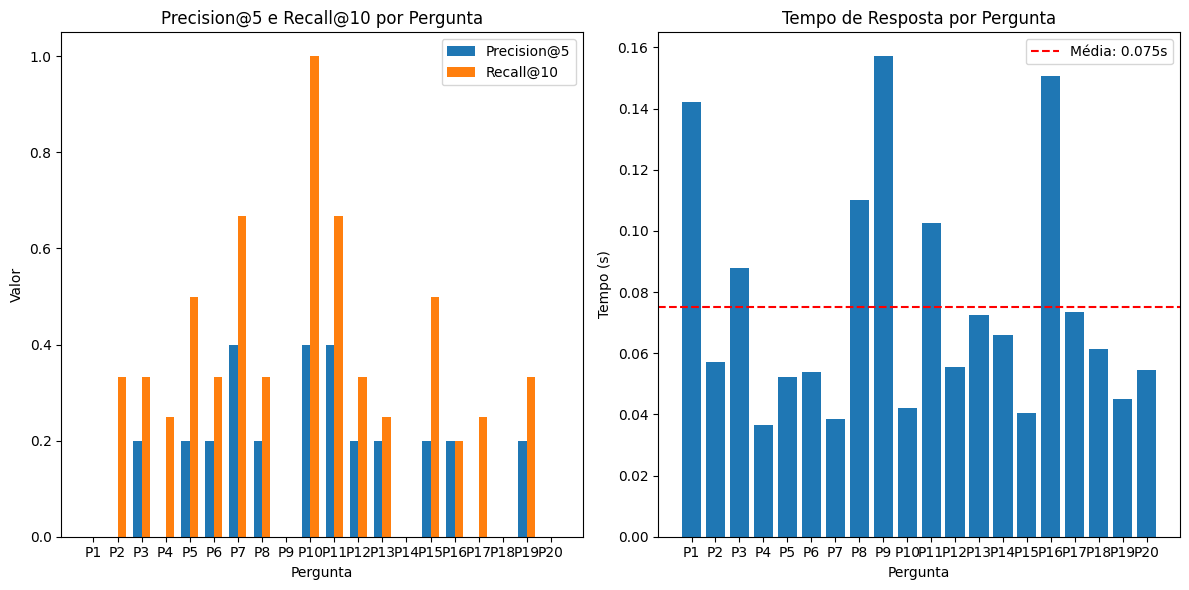

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Gráfico de barras para Precision@5 e Recall@10
plt.subplot(1, 2, 1)
x = np.arange(len(perguntas_teste))
width = 0.35

plt.bar(x - width/2, precision_at_5_list, width, label='Precision@5')
plt.bar(x + width/2, recall_at_10_list, width, label='Recall@10')

plt.xlabel('Pergunta')
plt.ylabel('Valor')
plt.title('Precision@5 e Recall@10 por Pergunta')
plt.xticks(x, [f"P{i+1}" for i in range(len(perguntas_teste))])
plt.legend()

# Gráfico de tempo de resposta
plt.subplot(1, 2, 2)
plt.bar(x, tempos_resposta)
plt.axhline(y=media_tempo_resposta, color='r', linestyle='--', label=f'Média: {media_tempo_resposta:.3f}s')
plt.xlabel('Pergunta')
plt.ylabel('Tempo (s)')
plt.title('Tempo de Resposta por Pergunta')
plt.xticks(x, [f"P{i+1}" for i in range(len(perguntas_teste))])
plt.legend()

plt.tight_layout()
plt.show()


## 9. Salvar Resultados

In [57]:
# Salvar resultados em CSV
df_resultados.to_csv('resultados_avaliacao_completa_enriquecida_otimizada.csv', index=False)

# Criar um resumo para relatório
resumo = {
    "versao": "completa_enriquecida_otimizada",
    "modelo": "neuralmind/bert-base-portuguese-cased",
    "indexador": "FAISS",
    "enriquecimento": "entidades_nomeadas_e_tokens_otimizado",
    "precision_at_5": float(media_precision_at_5),
    "recall_at_10": float(media_recall_at_10),
    "f1_score": float(media_f1),
    "ndcg": float(media_ndcg),
    "mrr": float(media_mrr),
    "tempo_resposta_medio": float(media_tempo_resposta),
    "precision_at_k": [float(p) for p in precision_at_5_list],
    "recall_at_k": [float(r) for r in recall_at_10_list],
    "ndcg_at_k": [float(n) for n in ndcg_list],
    "mrr_values": [float(m) for m in mrr_list],
    "tempos_resposta": [float(t) for t in tempos_resposta]
}

import json
with open('metricas_versao_completa_enriquecida_otimizada.json', 'w') as f:
    json.dump(resumo, f, indent=2)

print("\n[✓] Resultados salvos em 'resultados_avaliacao_completa_enriquecida_otimizada.csv' e 'metricas_versao_completa_enriquecida_otimizada.json'")



[✓] Resultados salvos em 'resultados_avaliacao_completa_enriquecida_otimizada.csv' e 'metricas_versao_completa_enriquecida_otimizada.json'
